In [63]:
import pandas as pd
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')


In [64]:
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['Recency'] = (pd.to_datetime('today') - merged_data['TransactionDate']).dt.days

rfm = merged_data.groupby('CustomerID').agg({
    'Recency': 'min',
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [65]:
from sklearn.preprocessing import StandardScaler
customer_features = pd.merge(customers, rfm, on='CustomerID')
features = customer_features[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
best_db_index = float('inf')
best_k = 0
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

    db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])

    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)


In [67]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, customer_features['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")
print(f"Best DB Index: {best_db_index} (for {best_k} clusters)")


Silhouette Score: 0.3835749274141815
Best DB Index: 0.8802576731688254 (for 3 clusters)


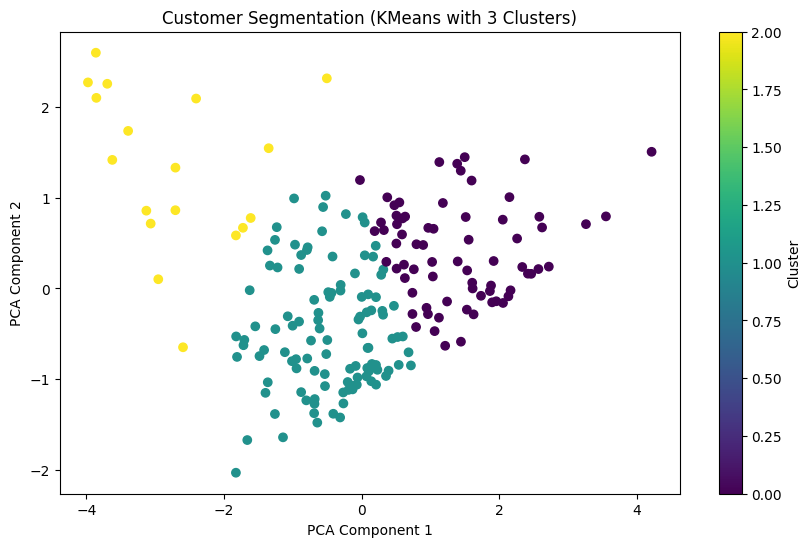

In [68]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title(f"Customer Segmentation (KMeans with {best_k} Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [69]:
report = {
    'Number of Clusters': n_clusters,
    'DB Index': db_index,
    'Cluster Centers': kmeans.cluster_centers_,
    'Inertia': kmeans.inertia_
}

print("Clustering Report:")
for key, value in report.items():
    print(f'{key}: {value}')


Clustering Report:
Number of Clusters: 3
DB Index: 1.116685147220865
Cluster Centers: [[-0.6838448   1.78418335  1.87644062]
 [-0.71103919 -0.01145819 -0.19986358]
 [ 1.01191938 -0.70892493 -0.46751346]
 [-0.39367735  0.9462173   1.0643245 ]
 [ 3.44125444 -1.70530599 -1.4446068 ]
 [-0.75575355 -0.87792649 -1.01136005]
 [ 0.5039562  -0.05946197  0.64798102]
 [ 1.7693569  -1.68358999 -1.57993043]
 [ 0.016126   -0.83232289 -0.75836128]
 [ 0.10406766  0.77624026 -0.0065309 ]]
Inertia: 92.90679323242011
